In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_squared_error


import warnings

from src.config import get_config
from src.data import load_train_test
from src.evaluation import evaluate_forecaster
from src.visualization import plot_pred_vs_actual

warnings.filterwarnings("ignore")

# Load data

In [2]:
config = get_config()

# Load data
train, test = load_train_test(path=config.processed_data_path)

# Get ony station 90
train = train[['90']].squeeze()
test = test[['90']].squeeze()

# Predict with the mean of the training data

In [3]:
train_mean = train.mean().round(0)

pred_mean = pd.Series(train_mean, index=test.index)

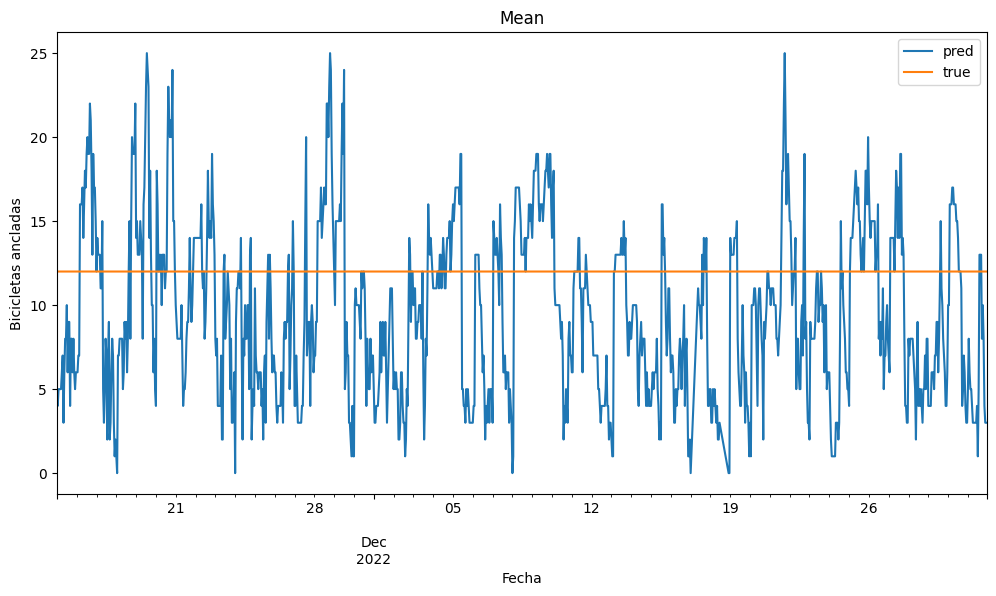

In [4]:
plot_pred_vs_actual(test, pred_mean, title='Mean')

In [5]:
mean_squared_error(test, pred_mean)

32.09807367409318

In [6]:
model = ExponentialSmoothing(sp=24*7, trend='add', seasonal='add')

model.fit(train)

pred = model.predict(fh=test.index).round(0)

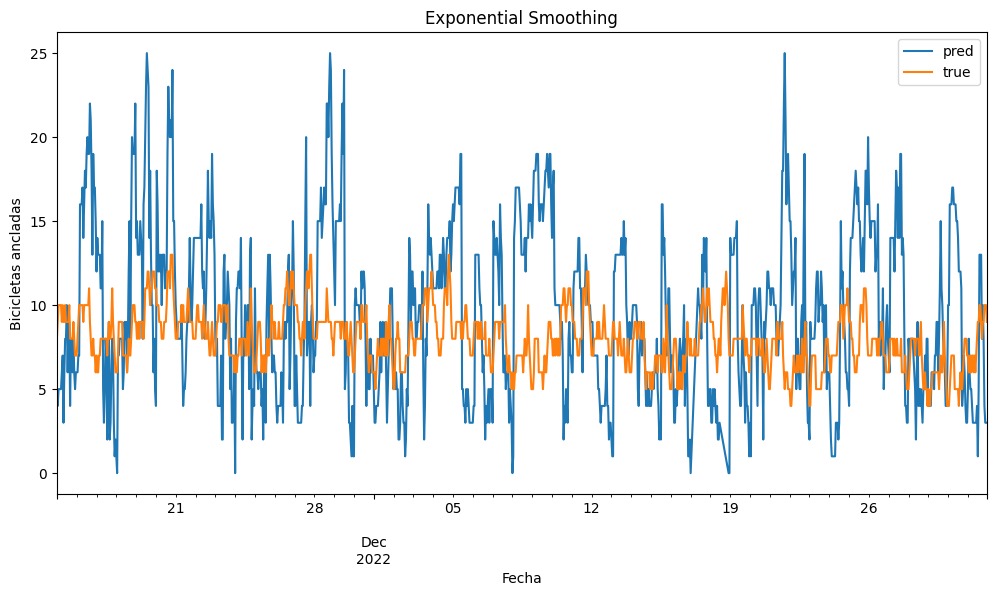

In [7]:
plot_pred_vs_actual(test, pred, title='Exponential Smoothing')

In [14]:
mean_squared_error(test, pred)

27.675568480311387

# Predict based on the previous n days

In [40]:
def get_n_days_before(df, n, date):
    """
    Returns the date n days before the given date.

    Parameters:
    - date: Date to consider.
    - n: Number of days before the given date.

    Returns:
    - A pandas Timestamp with the date n days before the given date.
    """
    return df[date - pd.DateOffset(days=n):date - pd.DateOffset(days=1):24]

def predict_hours(train, test, n):
    """
    Predicts hours based on the mean of the previous n days and continues predicting until the end_date.

    Parameters:
    - time_series: A pandas Series with datetime index containing the time series data.
    - n: Number of previous days to consider for the mean.
    - end_date: End date until which predictions will be made.

    Returns:
    - A pandas Series with the predicted hours.
    """
    full_time_series = pd.concat([train, test])
    predictions = full_time_series.copy(deep=True)

    date_range = pd.date_range(start=train.index[-1] + pd.DateOffset(hours=1), end=test.index[-1], freq='H')

    for date in date_range:
        # Calculate the mean of the previous n days and predict the hour
        previous_n_days = get_n_days_before(full_time_series, n, date)
        predictions[date] = previous_n_days.mean()

    return predictions[-len(date_range):]

pred_mean_31 = predict_hours(train, test, 31).round(0)

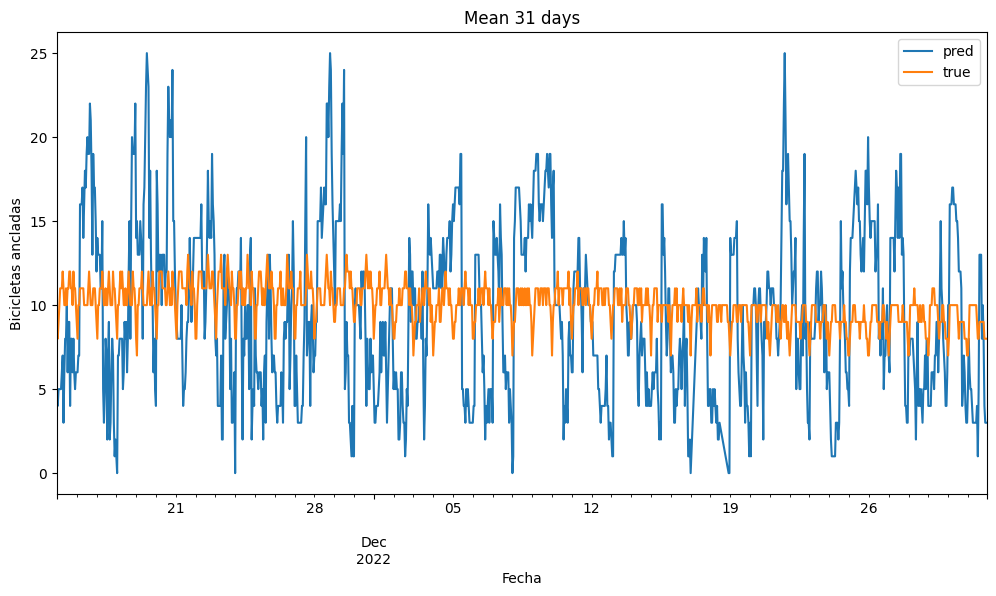

In [41]:
plot_pred_vs_actual(test, pred_mean_31, title='Mean 31 days')

In [42]:
mean_squared_error(test, pred_mean_31)

26.16220792439764